In [5]:
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    !git clone https://github.com/deepmind/pycolab.git
    !git clone https://github.com/nicoladainese96/RelationalModule.git
    !pip install pycolab

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
fatal: destination path 'pycolab' already exists and is not an empty directory.
fatal: destination path 'RelationalModule' already exists and is not an empty directory.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from RelationalModule import ActorCritic
from RelationalModule import train_agent as train
from importlib import reload

In [7]:
reload(train)

<module 'RelationalModule.train_agent' from '/content/RelationalModule/train_agent.py'>

In [0]:
game_params = dict(grid_size=7,
                solution_length=[0],
                num_forward = [0], # number of distractors
                num_backward=[0], # just set to 0 for now
                branch_length=1 # length of forward distractors
               )

In [9]:

HPs = dict(action_space=4,
           lr=5e-3,
           gamma=0.99,
           TD=True,
           twin=True,
           tau=0.2,
           n_steps=50
           )
if colab:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'

print('device: ', HPs['device'])  
agent = ActorCritic.BoxWorldA2C(**HPs)

device:  cuda


In [10]:
%%time
results = train.train_boxworld(agent, game_params, n_episodes = 5000, return_agent=True)
score, asymptotic_score, asymptotic_std, trained_agent, time_profile = results

/usr/local/lib/python3.6/dist-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


Streaming output truncated to the last 5000 lines.
Episode 4 - reward: 0
Episode 5 - reward: 0
Episode 6 - reward: 0
Episode 7 - reward: 0
Episode 8 - reward: 0
Episode 9 - reward: 0
Episode 10 - reward: 0
Episode 11 - reward: 0
Episode 12 - reward: 0
Episode 13 - reward: 0
Episode 14 - reward: 10
Episode 15 - reward: 0
Episode 16 - reward: 0
Episode 17 - reward: 0
Episode 18 - reward: 0
Episode 19 - reward: 0
Episode 20 - reward: 0
Episode 21 - reward: 10
Episode 22 - reward: 0
Episode 23 - reward: 0
Episode 24 - reward: 10
Episode 25 - reward: 0
Episode 26 - reward: 0
Episode 27 - reward: 0
Episode 28 - reward: 0
Episode 29 - reward: 0
Episode 30 - reward: 10
Episode 31 - reward: 0
Episode 32 - reward: 0
Episode 33 - reward: 0
Episode 34 - reward: 0
Episode 35 - reward: 0
Episode 36 - reward: 0
Episode 37 - reward: 0
Episode 38 - reward: 0
Episode 39 - reward: 0
Episode 40 - reward: 0
Episode 41 - reward: 0
Episode 42 - reward: 0
Episode 43 - reward: 0
Episode 44 - reward: 0
Episode 

On my PC:

 Average time for playing an episode: 1.97428691 <br>
 Average time for updating the agent: 26.46678982

 On Colab notebook:

 Average time for playing an episode:  1.11658633 <br>
 Average time for updating the agent: 18.63836179


With GPU

Average time for playing an episode: 0.43020332 <br>
Average time for updating the agent: 0.64481306


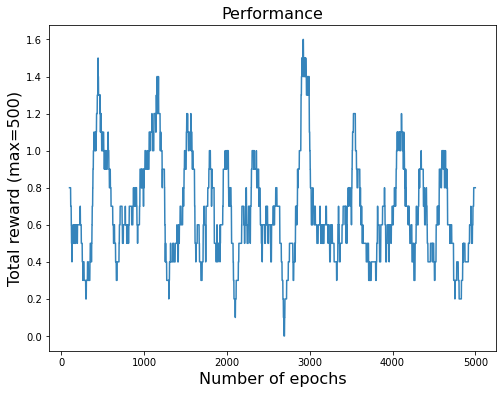

In [14]:
plt.figure(figsize=(8,6))
n_epochs = np.arange(100, len(score))
average_score = np.array([np.mean(score[i:i+100]) for i in range(len(score)-100)])
plt.plot(n_epochs, average_score, alpha=0.9)
plt.title("Performance", fontsize=16)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Total reward (max=500)", fontsize=16)
plt.show()

In [37]:
if colab:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    torch.save(trained_agent, save_dir+"trained_agent")

/root
/content/gdrive/My Drive/Colab Notebooks
mkdir: cannot create directory ‘RelationalTrained/’: File exists


In [30]:
reload = False
if reload:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    reloaded_agent = torch.load(parent_dir+save_dir+"trained_agent")

/root
